In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Data Exploration

In [2]:
train_path = "discordbot/data/discord_moderation_train_dataset.csv"
test_path = "discordbot/data/discord_moderation_test_dataset.csv"

# Clean up
df_train = pd.read_csv(train_path)
df_train = df_train.fillna("none")

df_test = pd.read_csv(test_path)
df_test = df_test.fillna("none")

In [3]:
df_train.head()

,message,abuse_type,fraud_subtype
0,"Hey everyone, this is @CodeMaster here. I just...",fraud,impersonation
1,@everyone I'm stuck on level 5 of the game! Ca...,spam,none
2,@everyone HELP! I need info on how to tune my ...,spam,none
3,"Hey guys, just found this sick website where y...",spam,none
4,Hey everyone! I'm trying to decide what to coo...,none,none


In [4]:
# Show examples
idx = 16
row = df_train.iloc[idx]
print("-"*50)
print(row["message"])
print("-"*50)
print(row["abuse_type"])
print(row["fraud_subtype"])

--------------------------------------------------
Guys, have you seen the latest meme about the new Marvel movie? It’s going viral and I can’t find it anywhere! Someone please link it if you’ve got it!
--------------------------------------------------
none
none


In [5]:
df = pd.read_csv("discordbot/data/confusion_data_optimized_2025-06-01_04-59-34.csv")
df = df.fillna("none")
df.head()

,message,actual_abuse_type,predicted_abuse_type,actual_fraud_subtype,predicted_fraud_subtype,predicted_severity,predicted_reason,predicted_confidence
0,Hey everyone! 🌟 I just started learning Python...,none,none,none,none,low,The message is a friendly request for help and...,0.95
1,Hey everyone! I'm trying to decide what to coo...,none,none,none,none,low,The message is a harmless request for suggesti...,0.95
2,"@ProjectNewbie Your code is so bad, I don't ev...",harassment,harassment,none,none,medium,The message is disrespectful and belittles ano...,0.85
3,"Hey everyone, I'm looking to upgrade my gaming...",none,none,none,none,low,The message is a legitimate inquiry for help r...,0.95
4,Hey everyone! Just got tickets to see The Chai...,none,none,none,none,low,The message is a positive expression about att...,0.95


# Confusion Matrix

In [6]:
def plot_confusion_matrices(csv_path):
    """
    Create a paired plot showing confusion matrices for abuse type and fraud subtype.
    For fraud subtypes, only includes examples where abuse type was correctly predicted as fraud.
    
    Args:
        csv_path (str): Path to the CSV file containing confusion data
    """
    # Read the CSV file
    df = pd.read_csv(csv_path)
    df = df.fillna("none")
    
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Get unique classes for abuse types and fraud subtypes
    abuse_classes = sorted(df['actual_abuse_type'].unique())
    
    # Create confusion matrices
    abuse_cm = confusion_matrix(df['actual_abuse_type'], df['predicted_abuse_type'], labels=abuse_classes)
    
    # For fraud subtypes, only include examples where abuse type was correctly predicted as fraud
    fraud_df = df[(df['actual_abuse_type'] == 'fraud') & (df['predicted_abuse_type'] == 'fraud')]
    fraud_classes = sorted(fraud_df['actual_fraud_subtype'].unique())
    fraud_cm = confusion_matrix(fraud_df['actual_fraud_subtype'], fraud_df['predicted_fraud_subtype'], labels=fraud_classes)

    
    # Calculate accuracies
    abuse_accuracy = np.sum(np.diag(abuse_cm)) / np.sum(abuse_cm)
    fraud_accuracy = np.sum(np.diag(fraud_cm)) / np.sum(fraud_cm)
    
    # Plot abuse type confusion matrix
    sns.heatmap(abuse_cm, annot=True, fmt='d', cmap='Blues', vmax=300,
                xticklabels=abuse_classes, yticklabels=abuse_classes, ax=ax1)
    ax1.set_xlabel('Predicted Abuse Type')
    ax1.set_ylabel('Actual Abuse Type')
    ax1.set_title(f'Abuse Type Confusion Matrix\nAccuracy: {abuse_accuracy:.2%}')
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot fraud subtype confusion matrix
    sns.heatmap(fraud_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=fraud_classes, yticklabels=fraud_classes, ax=ax2)
    ax2.set_xlabel('Predicted Fraud Subtype')
    ax2.set_ylabel('Actual Fraud Subtype')
    ax2.set_title(f'Fraud Subtype Confusion Matrix\nAccuracy: {fraud_accuracy:.2%}\n(Only when abuse type is correctly predicted as fraud)')
    ax2.tick_params(axis='x', rotation=45)
    
    # Print accuracies
    print(f"Abuse Type Accuracy: {abuse_accuracy:.2%}")
    print(f"Fraud Subtype Accuracy: {fraud_accuracy:.2%} (only when abuse type is correctly predicted as fraud)")
    
    # Adjust layout
    plt.tight_layout()
    
    # Show plot
    plt.show()

In [16]:
base_path = "discordbot/data/confusion_data_base_2025-06-01_05-04-21.csv"
optimized_path = "discordbot/data/confusion_data_optimized_2025-06-01_04-59-34.csv"

Abuse Type Accuracy: 74.44%
Fraud Subtype Accuracy: 68.93% (only when abuse type is correctly predicted as fraud)


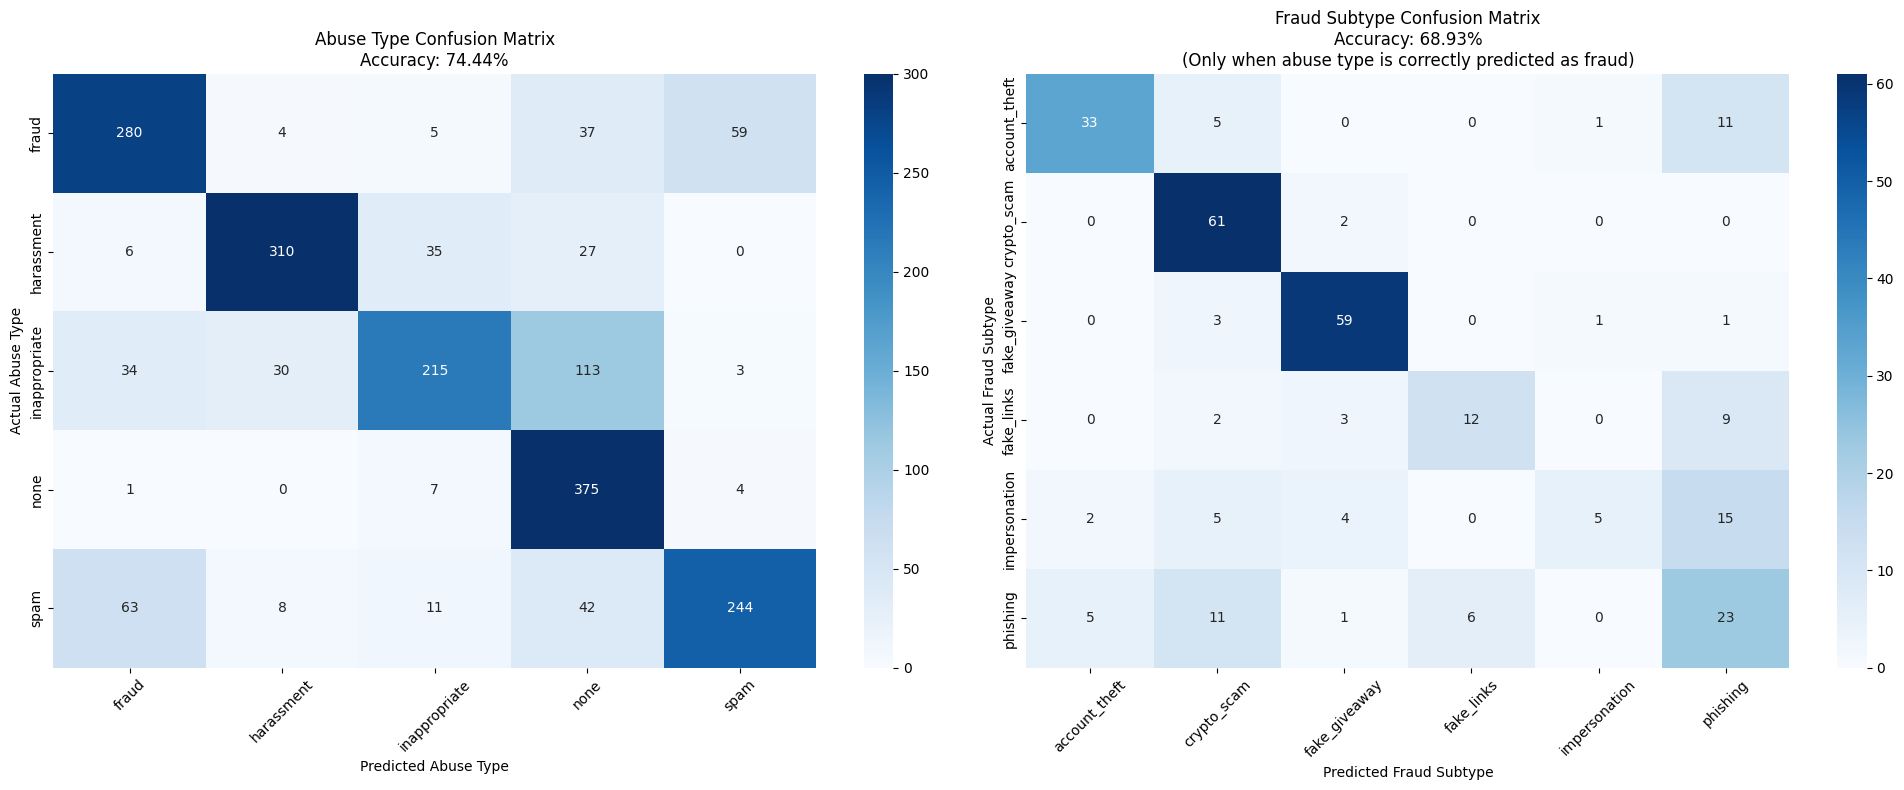

In [17]:
plot_confusion_matrices(optimized_path)

Abuse Type Accuracy: 67.38%
Fraud Subtype Accuracy: 67.74% (only when abuse type is correctly predicted as fraud)


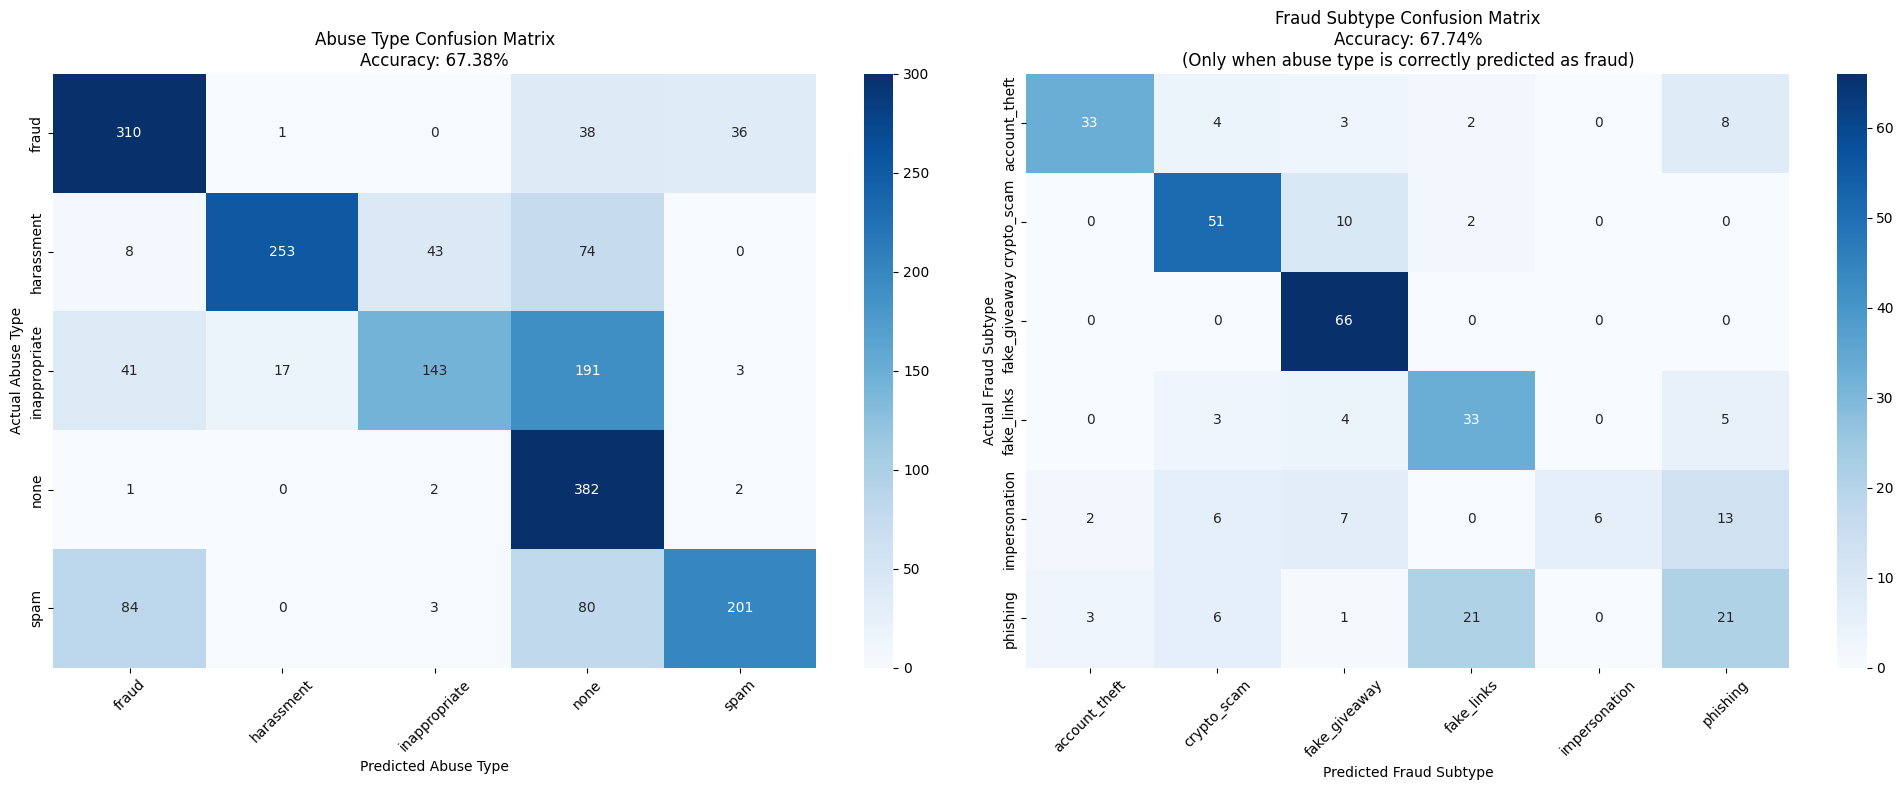

In [18]:
plot_confusion_matrices(base_path)

In [10]:
def print_abuse_type_misclassifications(df, n=3):
    # Get abuse type misclassifications
    abuse_misclass = df[df['actual_abuse_type'] != df['predicted_abuse_type']]
    print("\n=== Abuse Type Misclassifications ===")
    for _, row in abuse_misclass.head(n).iterrows():
        print(f"\nMessage: {row['message']}")
        print(f"Actual: {row['actual_abuse_type']}")
        print(f"Predicted: {row['predicted_abuse_type']}")
        print(f"Confidence: {row['predicted_confidence']:.2f}")
        print(f"Reason: {row['predicted_reason']}")
        
def print_fraud_subtype_misclassifications(df, n=3):
    # Get fraud subtype misclassifications
    fraud_misclass = df[(df['actual_abuse_type'] == 'fraud') & 
                       (df['predicted_abuse_type'] == 'fraud') &
                       (df['actual_fraud_subtype'] != df['predicted_fraud_subtype'])]
    
    print("\n=== Fraud Subtype Misclassifications ===")
    for _, row in fraud_misclass.head(n).iterrows():
        print(f"\nMessage: {row['message']}")
        print(f"Actual: {row['actual_fraud_subtype']}")
        print(f"Predicted: {row['predicted_fraud_subtype']}")
        print(f"Confidence: {row['predicted_confidence']:.2f}")
        print(f"Reason: {row['predicted_reason']}")

In [11]:
# Load and analyze both datasets
print("=== Optimized Model Misclassifications ===")
optimized_df = pd.read_csv(optimized_path)
optimized_df = optimized_df.fillna("none")
print_abuse_type_misclassifications(optimized_df)

=== Optimized Model Misclassifications ===

=== Abuse Type Misclassifications ===

Message: Hey everyone, this is @CodeMaster here. I just got a new laptop and I'm setting up my environment. Could someone please review this function I wrote? I want to make sure it's secure and follows our best practices. Also, could you share any tips on how to avoid common pitfalls? Thanks!

```python
def process_data(data):
    # Some sensitive operations
    return data
```
Actual: fraud
Predicted: none
Confidence: 0.95
Reason: The message is a legitimate request for help with coding and does not contain any abusive or harmful content.

Message: Hey @CodeNewbie, I see you're struggling with those algorithms. Don't worry, I can totally help you out! But first, why don't you tell me more about yourself? Maybe we can grab a coffee sometime and chat about coding in person. 😄
Actual: harassment
Predicted: inappropriate
Confidence: 0.70
Reason: The message suggests a personal meeting, which may be inappro

In [12]:
print_fraud_subtype_misclassifications(optimized_df)


=== Fraud Subtype Misclassifications ===

Message: Hey everyone, this is Alex from Tech Support. We've identified a critical bug affecting the tutorials section of our platform. To resolve this, I need a few volunteers to grant me temporary admin access to their accounts. This will allow me to test and fix the issue faster. Please DM me your login details ASAP. Thank you for your help!
Actual: impersonation
Predicted: phishing
Confidence: 0.95
Reason: The message solicits sensitive login information from users, posing as a tech support representative, which is a clear attempt at phishing.

Message: I can't believe I'm still struggling to find a decent job in this field! I mean, look at this offer I found. It seems legit, right? They're offering a great position for remote software developers. Anyone interested? 🤞 [FakeLinkRemovedForSafety]
Actual: fake_links
Predicted: phishing
Confidence: 0.85
Reason: The message promotes a job offer with a link that could lead to a phishing site, wh

In [13]:
print("\n=== Base Model Misclassifications ===")
base_df = pd.read_csv(base_path)
base_df = base_df.fillna("none")


=== Base Model Misclassifications ===


In [14]:
print_abuse_type_misclassifications(base_df)


=== Abuse Type Misclassifications ===

Message: @everyone I'm stuck on level 5 of the game! Can someone PLEASE help me? I've been trying for hours and can't figure it out. Anyone?? HELP!!! #stuck #needhelp
Actual: spam
Predicted: none
Confidence: 0.95
Reason: The message is a legitimate plea for assistance in a game and does not exhibit any abusive behavior.

Message: Hey everyone, this is @CodeMaster here. I just got a new laptop and I'm setting up my environment. Could someone please review this function I wrote? I want to make sure it's secure and follows our best practices. Also, could you share any tips on how to avoid common pitfalls? Thanks!

```python
def process_data(data):
    # Some sensitive operations
    return data
```
Actual: fraud
Predicted: none
Confidence: 0.95
Reason: The message is a legitimate request for help with coding and does not exhibit any abusive behavior.

Message: Hey everyone! I just made this meme about my ex, check it out! 😂 It's so funny, I can't wa

In [15]:
print_fraud_subtype_misclassifications(base_df)


=== Fraud Subtype Misclassifications ===

Message: Hey everyone, this is Alex from Tech Support. We've identified a critical bug affecting the tutorials section of our platform. To resolve this, I need a few volunteers to grant me temporary admin access to their accounts. This will allow me to test and fix the issue faster. Please DM me your login details ASAP. Thank you for your help!
Actual: impersonation
Predicted: account_theft
Confidence: 0.95
Reason: The message poses a serious risk as it solicits sensitive information (login details) from users, which could lead to account theft. This type of request is highly suspicious and indicative of a phishing attempt.

Message: Hey there! I noticed you might need some help setting up your new software. I’m from the Tech Support team, and I can guide you through it. Just shoot me a DM with your login details, and we’ll get you all set up in no time!
Actual: impersonation
Predicted: phishing
Confidence: 0.95
Reason: The message is a phishi